# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import beta, gaussian_kde, norm, gamma, multivariate_normal, binom
import seaborn as sns
from sklearn.neighbors import KernelDensity
from theano import tensor as tt

%matplotlib inline

# Function definitions

In [2]:
def multiply_odds(p, odds_multiplier):
    p = np.array(p)
    odds_multiplier = np.array(odds_multiplier)
    assert 0.0 < p.min()
    assert p.max() < 1.0
    assert (odds_multiplier >= 0).all()
    old_odds = p / (1 - p)
    new_odds = old_odds * odds_multiplier
    new_p = new_odds / (1 + new_odds)
    return new_p

In [3]:
def relative_binom_log_likelihood(p: np.ndarray, n: int, x: int):
    # the combinatorial factor is common to all p given fixed (n, x)
    return np.log(p)*x + np.log(1-p)*(n-x)

In [4]:
def expected_loss(likelihood_grid, value_grid):
    # returns a positive number for the expected loss
    likelihood_grid = likelihood_grid / likelihood_grid.sum()
    weighted_value_grid = likelihood_grid * value_grid
    if weighted_value_grid.sum() > 0:
        weighted_value_grid *= -1.0
    return weighted_value_grid.clip(0).sum()

# Constants

In [5]:
EMPIRICAL_P_LOAN = 0.1
N_QUANTILES = 7
UNIVARIATE_SAMPLE_SIZE = 10000
COPULA_SAMPLE_SIZE = 100
COVARIANCE = -0.7

# Get reference data

In [6]:
reference_data = pd.read_csv('../../../Documents/iwoca/ab_testing/reference_data_for_empirical_dist.csv')
empirical_n_loans = len(reference_data)
empirical_cltvs = reference_data['cltv_total_initial']
min_cltv = empirical_cltvs.min()
max_cltv = empirical_cltvs.max()
range_cltv = max_cltv - min_cltv

# Control priors

## Prior over p(loan)

In [7]:
rate_prior = beta(empirical_n_loans, empirical_n_loans*(1-EMPIRICAL_P_LOAN)/EMPIRICAL_P_LOAN)
quantile_points = np.linspace(1/(N_QUANTILES*2), 1-1/(N_QUANTILES*2), N_QUANTILES)
p_prior_quantiles = rate_prior.ppf(quantile_points)
p_prior_quantiles

array([0.09302423, 0.0961628 , 0.09817776, 0.09993127, 0.10170321,
       0.1037859 , 0.10713345])

## Prior over CLTV scale factor

### Build kernel estimator as empirical distribution

In [8]:
# exponential kernel chosen as most appropriate for extrapolation
# bandwidth selected by inspection
empirical_cltv_kde = KernelDensity(kernel='exponential', bandwidth=4500.)
empirical_cltv_kde.fit(empirical_cltvs.values.reshape(-1, 1))

KernelDensity(bandwidth=4500.0, kernel='exponential')

### Approximate KDE using pymc.Interpolated to allow estimation and calibration of the scale factor

In [9]:
x_points = np.concatenate([
    np.linspace(min_cltv - range_cltv, min_cltv, 100),
    np.array(empirical_cltvs.sort_values())[1:-1],
    np.linspace(max_cltv, max_cltv + range_cltv, 100),
])

pdf_points = np.exp(empirical_cltv_kde.score_samples(x_points.reshape(-1, 1)))
empirical_cltv_dist = pm.Interpolated.dist(x_points, pdf_points)

### Log PDF

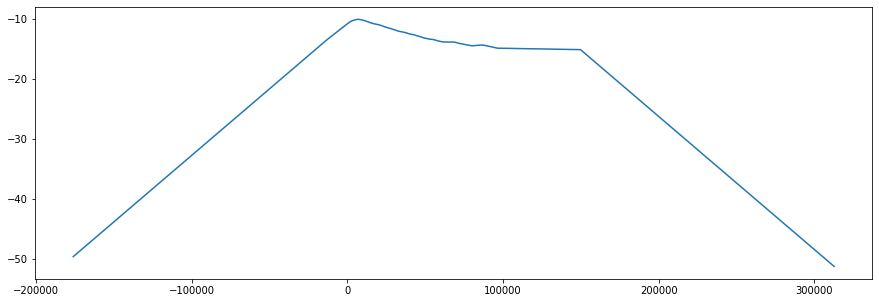

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_points, empirical_cltv_dist.logp(x_points).eval());

### CDF

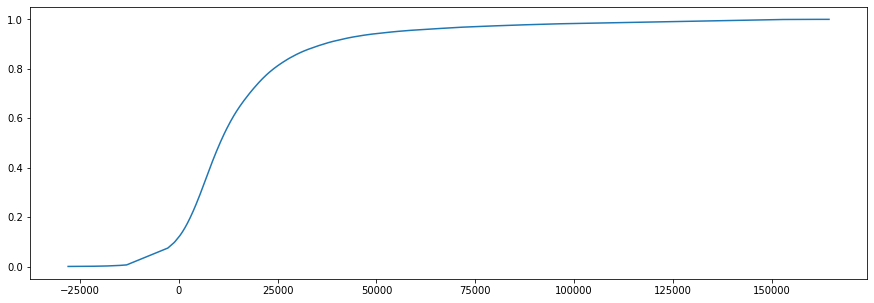

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(empirical_cltv_dist.x_points[90:-90], empirical_cltv_dist.cdf_points[90:-90]);

### PDF vs histogram of reference data

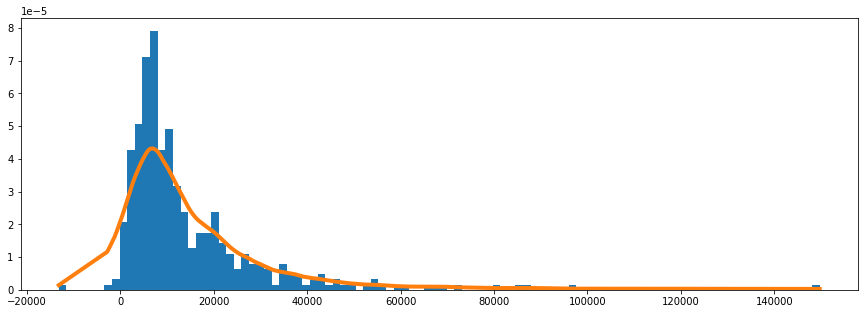

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(empirical_cltvs, bins=100, density=True)
x = np.linspace(min_cltv, max_cltv, 300)
y = np.exp(empirical_cltv_dist.logp(x).eval())
ax.plot(x, y, lw=4);

### Estimate the log scale factor for the reference data (should be ≈ 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


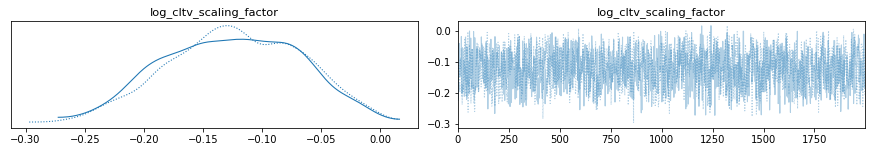

In [13]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -1.0, 1.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)
    
    # plot
    log_cltv_scale_prior_trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace)

### Calibrate the distribution to ensure log scale factor ≈ 0

In [14]:
# a retrospective scaling factor introduced to counteract the smoothing (stretching) effect of
# kernel density estimation
CALIBRATION_FACTOR = np.exp(-0.11)
CALIBRATION_FACTOR

0.8958341352965282

In [15]:
empirical_cltv_kde.fit((empirical_cltvs * CALIBRATION_FACTOR).values.reshape(-1, 1))
pdf_points = np.exp(empirical_cltv_kde.score_samples(x_points.reshape(-1, 1)))
empirical_cltv_dist_calibrated = pm.Interpolated.dist(x_points, pdf_points)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_cltv_scaling_factor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


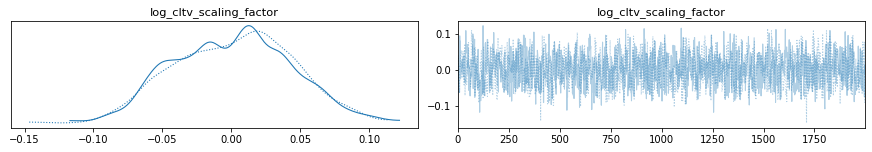

In [16]:
obs_cltv = np.array(empirical_cltvs.sort_values())

with pm.Model() as cltv_model:
    # prior
    log_cltv_scaling_factor = pm.Uniform('log_cltv_scaling_factor', -1.0, 1.0)
    
    # this returns the correct density in the transformed space
    def scaled_empirical_logp(value):
        return empirical_cltv_dist_calibrated.logp(value/tt.exp(log_cltv_scaling_factor)) - log_cltv_scaling_factor
    
    # parameterisation
    cltv = pm.DensityDist('cltv', scaled_empirical_logp, observed=obs_cltv)
    
    # plot
    log_cltv_scale_prior_trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    pm.plot_trace(log_cltv_scale_prior_trace)

In [17]:
# uncomment the line below to check that the expected value of the log scale factor is ~0
# log_cltv_scale_prior_trace.mean()

### PDF vs histogram of reference data

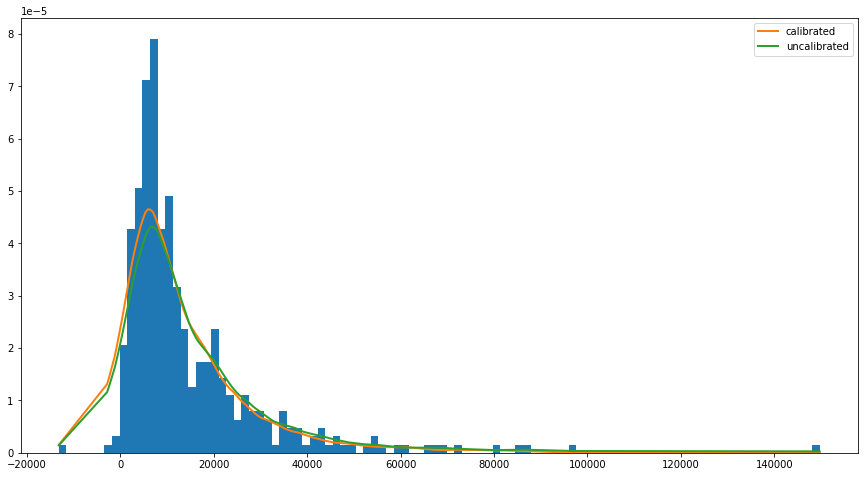

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(empirical_cltvs, bins=100, density=True)
x = np.linspace(min_cltv, max_cltv, 300)
y = np.exp(empirical_cltv_dist.logp(x).eval())
y_calibrated = np.exp(empirical_cltv_dist_calibrated.logp(x).eval())
ax.plot(x, y_calibrated, lw=2, label="calibrated")
ax.plot(x, y, lw=2, label="uncalibrated")
plt.legend();

### Derive the prior over the CLTV scale factor by using the trace

In [19]:
quantile_points = np.linspace(1/(N_QUANTILES*2), 1-1/(N_QUANTILES*2), N_QUANTILES)
log_cltv_scale_prior_quantiles = ((log_cltv_scale_prior_trace.to_dataframe().iloc[:,2])
                                  .quantile(quantile_points)
                                  .values)
log_cltv_scale_prior_quantiles

array([-0.06045065, -0.03530546, -0.01522327,  0.00393714,  0.01889454,
        0.03701259,  0.06323596])

### Build a quick_kde function to approximate density
This is used later in the simulation to allow vectorised calculation of densities

In [20]:
quick_kde_eval_points = np.linspace(min_cltv - range_cltv, max_cltv + range_cltv, 10000)
quick_kde_pdf_points = empirical_cltv_kde.score_samples(quick_kde_eval_points.reshape(-1,1))
    
def quick_kde(cltvs):    
    return np.interp(cltvs, quick_kde_eval_points, quick_kde_pdf_points)

In [21]:
def cltv_log_likelihood(observed_values, scale_factors):
    evaluation_points = np.divide.outer(observed_values, scale_factors)
    evaluation_shape = evaluation_points.shape
    return (quick_kde(evaluation_points.reshape(-1,1))
            .reshape(evaluation_shape)
            - np.log(scale_factors)).sum(axis=0)

# Collect marginal priors over uplifts

## p(loan)

In [22]:
# let's start by assuming that the effect size on p(loan) is unlikely to be more extreme than e.g. 4x
max_odds_mult = 4
N_bins = 10

max_logit = np.log(max_odds_mult)
logit_bin_edges = np.linspace(-max_logit, max_logit, N_bins+1)
logit_bin_midps = np.linspace(-max_logit, max_logit, 2*N_bins+1)[1::2]

In [23]:
# convert dummy survey data for these bins into a distribution that pymc3 can use
# pymc3 is only used for sampling
# NB the interpolation could be improved by extending the list of midpoints with the outside bin edges (at which y=0)
dummy_odds_survey_data = np.array([1,2,5,12,20,31,18,7,3,1])
log_odds_multiplier_prior = pm.Interpolated.dist(logit_bin_midps, dummy_odds_survey_data)

## E(CLTV | loan)

In [24]:
# let's assume that the effect size on CLTV is unlikely to be more extreme than e.g. 2x
max_cltv_mult = 2
N_bins = 10

max_log_cltv_mult = np.log(max_cltv_mult)
log_cltv_bin_edges = np.linspace(-max_log_cltv_mult, max_log_cltv_mult, N_bins+1)
log_cltv_bin_midps = np.linspace(-max_log_cltv_mult, max_log_cltv_mult, 2*N_bins+1)[1::2]

np.exp(log_cltv_bin_edges)

array([0.5       , 0.57434918, 0.65975396, 0.75785828, 0.87055056,
       1.        , 1.14869835, 1.31950791, 1.51571657, 1.74110113,
       2.        ])

In [25]:
# convert dummy survey data for these bins into a distribution that pymc3 can use
# pymc3 is only used for sampling
# NB the interpolation could be improved by extending the list of midpoints with the outside bin edges (at which y=0)
dummy_cltv_survey_data = np.array([1,2,7,15,21,25,16,9,3,1])
log_cltv_uplift_prior = pm.Interpolated.dist(log_cltv_bin_midps, dummy_cltv_survey_data)

# Construct the 2-D prior

In [26]:
# This is the only place I'm currently using pymc3 (the "frozen" prior distributions)
# I could probably get them from elsewhere if necessary (see below)
log_odds_multiplier_sample = log_odds_multiplier_prior.random(size=UNIVARIATE_SAMPLE_SIZE)
log_cltv_uplift_sample = log_cltv_uplift_prior.random(size=UNIVARIATE_SAMPLE_SIZE)

## Apply a copula

In [27]:
cov_matrix = [[1., COVARIANCE], [COVARIANCE, 1.]]
mv_norm = multivariate_normal(mean=[0, 0], cov=cov_matrix)
mv_norm_rvs = mv_norm.rvs(COPULA_SAMPLE_SIZE)

In [28]:
mv_norm_cdfs = norm.cdf(mv_norm_rvs)

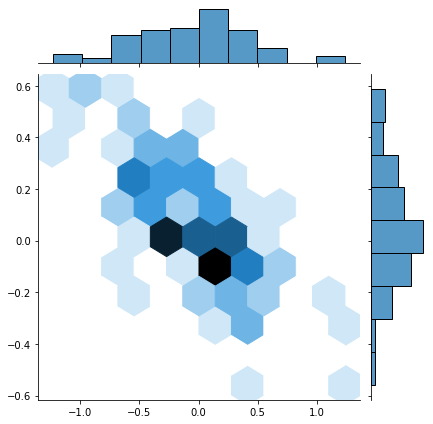

In [29]:
log_odds_multiplier_sample_sorted = np.sort(log_odds_multiplier_sample)
log_cltv_uplift_sample_sorted = np.sort(log_cltv_uplift_sample)

log_odds_multiplier_prior_coupled = log_odds_multiplier_sample_sorted[np.floor(mv_norm_cdfs[:,0] * UNIVARIATE_SAMPLE_SIZE).astype(int)]
log_cltv_uplift_prior_coupled = log_cltv_uplift_sample_sorted[np.floor(mv_norm_cdfs[:,1] * UNIVARIATE_SAMPLE_SIZE).astype(int)]

sns.jointplot(x=log_odds_multiplier_prior_coupled, y=log_cltv_uplift_prior_coupled, kind='hex');

# Evaluate the test by running simulations

## Setup prior grids

In [30]:
# value_grid
value_grid = np.empty(shape=(len(p_prior_quantiles),
                             len(log_cltv_scale_prior_quantiles),
                             len(log_odds_multiplier_prior_coupled)))

p_A_grid = np.empty_like(value_grid)
p_B_grid = np.empty_like(value_grid)
cltv_A_grid = np.empty_like(value_grid)
cltv_B_grid = np.empty_like(value_grid)

In [31]:
for i, p_A in enumerate(p_prior_quantiles):
    p_A_grid[i,:,:] = p_A
    
    for j, cltv_scale_A in enumerate(log_cltv_scale_prior_quantiles):
        cltv_A = np.exp(cltv_scale_A)
        cltv_A_grid[:,j,:] = cltv_A
        
        for k, (odds_multiplier, cltv_uplift) in enumerate(zip(log_odds_multiplier_prior_coupled,
                                                               log_cltv_uplift_prior_coupled)):
            # calculate underlying "true" values
            p_B = multiply_odds(p_A, np.exp(odds_multiplier))
            p_B_grid[i,:,k] = p_B
            
            cltv_B = cltv_A * np.exp(cltv_uplift)
            cltv_B_grid[:,j,k] = cltv_B
            
            B_minus_A = (p_B * cltv_B) - (p_A * cltv_A)
            value_grid[i,j,k] = B_minus_A

In [32]:
optimal_choice_grid = np.where(value_grid > 0, 'B', 'A')

## Check initial expected loss and choice (from priors alone)

In [33]:
prior_expected_loss = expected_loss(np.ones_like(value_grid), value_grid)
initial_choice = 'B' if value_grid.sum() > 0 else 'A'
prior_expected_loss, initial_choice

(0.009587447130434327, 'B')

In [34]:
value_grid.mean()

0.006277695137272431

## Run simulation

In [35]:
def run_simulation(threshold_loss, batch_size):
    results = []
    counter = 0
    for ijk in np.ndindex(value_grid.shape):
        # reset initial values
        exp_loss = prior_expected_loss
        N_apps = 0
        N_loans_A = 0
        N_loans_B = 0
        cltvs_A = []
        cltvs_B = []

        # do simulation
        while exp_loss > threshold_loss:

            # simulate applications
            N_apps += batch_size
            n_loans_A = binom.rvs(batch_size, p_A_grid[ijk])
            n_loans_B = binom.rvs(batch_size, p_B_grid[ijk])
            N_loans_A += n_loans_A
            N_loans_B += n_loans_B
            cltvs_A = np.concatenate([cltvs_A, empirical_cltv_dist.random(size=n_loans_A) * cltv_A_grid[ijk]])
            cltvs_B = np.concatenate([cltvs_B, empirical_cltv_dist.random(size=n_loans_B) * cltv_B_grid[ijk]])

            # calculate log likelihoods
            ll_N_loans_A = relative_binom_log_likelihood(p_A_grid, N_apps, N_loans_A)
            ll_N_loans_B = relative_binom_log_likelihood(p_B_grid, N_apps, N_loans_B)

            ll_cltvs_A = cltv_log_likelihood(cltvs_A, cltv_A_grid)
            ll_cltvs_B = cltv_log_likelihood(cltvs_B, cltv_B_grid)

            total_ll = ll_N_loans_A + ll_N_loans_B + ll_cltvs_A + ll_cltvs_B
            total_ll_shifted = total_ll - total_ll.max()

            exp_loss = expected_loss(np.exp(total_ll_shifted), value_grid)

        # the cost is negative if the initial_choice was not the true optimal choice
        if initial_choice == optimal_choice_grid[ijk]:
            inferior_branch_cost = abs(value_grid[ijk]) * N_apps
        else:
            inferior_branch_cost = -abs(value_grid[ijk]) * N_apps

        results.append({
            'value_ijk': value_grid[ijk],
            'inferior_branch_cost': inferior_branch_cost,
            'N_apps': N_apps,
            'exp_loss_change': exp_loss - prior_expected_loss,
        })
        counter += 1
        if counter % 100 == 0:
            print('.', end='')

    results = pd.DataFrame(results)
    expected_inferior_branch_cost = results['inferior_branch_cost'].mean()
    expected_duration = results['N_apps'].mean() * 2
    expected_benefit_per_app = -results['exp_loss_change'].mean()

    summary = {
        'expected_inferior_branch_cost': expected_inferior_branch_cost,
        'expected_duration_in_apps': expected_duration,
        'expected_benefit_per_app': expected_benefit_per_app,
    }
    
    return results, summary

In [36]:
hyper_results = []
for threshold in np.linspace(0.99, 0.3, 5) * prior_expected_loss:
    _, summary = run_simulation(threshold, 100)
    summary['threshold'] = threshold
    hyper_results.append(summary)
    print(f'threshold {threshold} complete...')
hyper_results = pd.DataFrame(hyper_results)

.................................................threshold 0.009491572659129983 complete...
.................................................threshold 0.007837738029130063 complete...
.................................................threshold 0.006183903399130141 complete...
.................................................threshold 0.0045300687691302195 complete...
.................................................threshold 0.002876234139130298 complete...


# Specify the costs and benefits of running the test

In [37]:
current_value_per_app = p_A_grid.mean() * empirical_cltvs.mean()
current_value_per_app

1469.2026943230248

In [38]:
def profit_optimisation(results_df, upfront_cost=0, maintenance_cost_per_app=0,
                        value_per_app=1, half_life_in_apps=None):
    results_df = results_df.copy()
    results_df['expected_inferior_branch_cost'] = results_df['expected_inferior_branch_cost'] * value_per_app
    results_df['upfront_cost'] = upfront_cost
    results_df['maintenance_cost'] = maintenance_cost_per_app * results_df['expected_duration_in_apps']
    results_df['total_benefit'] = (results_df['expected_benefit_per_app']
                                   * value_per_app
                                   * half_life_in_apps/np.log(2))
    results_df['total_cost'] = (results_df['expected_inferior_branch_cost']
                                + results_df['upfront_cost']
                                + results_df['maintenance_cost'])
    results_df['total_profit'] = results_df['total_benefit'] - results_df['total_cost']
    return results_df

In [39]:
profit_optimisation(
    results_df=hyper_results,
    upfront_cost=5000,
    maintenance_cost_per_app=10,
    value_per_app=current_value_per_app,
    half_life_in_apps=1000,
)

,expected_inferior_branch_cost,expected_duration_in_apps,expected_benefit_per_app,threshold,upfront_cost,maintenance_cost,total_benefit,total_cost,total_profit
0,914.486522,203.061224,0.005668,0.009492,5000,2030.612245,12014.897520,7945.098767,4069.798753
1,901.316652,225.673469,0.006145,0.007838,5000,2256.734694,13025.304040,8158.051346,4867.252694
2,862.456662,274.000000,0.006651,0.006184,5000,2740.000000,14098.406158,8602.456662,5495.949497
3,683.157027,354.408163,0.007324,0.004530,5000,3544.081633,15524.376717,9227.238660,6297.138057
4,328.119003,533.469388,0.008063,0.002876,5000,5334.693878,17091.077973,10662.812881,6428.265092


Interestingly, the `expected_inferior_branch_cost` seems relatively stable. My theory for this is that as the threshold is lowered, the test will run for longer in both cases where the original_choice was optimal (cost is positive) and where it was suboptimal (cost is negative). However it will tend to run for **much** longer in the suboptimal initial choice case as the expected loss typically needs to increase before it decreases for these cases. Therefore more time is spent on average accumulating negative cost. Also, this test starts from quite an uncertain position, whereas a test with a stronger initial prior favourite would be expected to accumulate higher opportunity costs of testing.